# Probabilistic Programming 4: Gaussian dynamical systems
## Variational inference

### Preliminaries

- Goal 
  - Learn to apply ForneyLab to a dynamical system.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
      - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
      - David Blei (https://doi.org/10.1146/annurev-statistics-022513-115657)

In [ ]:
# Package managing
using Pkg
Pkg.activate("workspace")
Pkg.instantiate()

include("../scripts/pp-4.jl")

using Logging; disable_logging(LogLevel(0))
using LinearAlgebra
using LaTeXStrings
using ForneyLab
using Plots
pyplot();

## Data generation

In this notebook, we will be considering continuous state-space models. We will focus on the simplest form: the Gaussian dynamical system:

$$\begin{align}
x_k =&\ A x_{k-1} + \epsilon_{k} \\
y_k =&\ B x_k + \eta_k \, ,
\end{align}$$

where $x_k \in \mathbb{R}^{N}$ is the state, $y_k \in \mathbb{R}^{M}$ is the measurement. Process noise and measurement noise are assumed to be zero mean Gaussian with covariance matrices $Q$ and $R$ respectively. 

We'll generate the data in the same manner as the HMM setting. We start with an initial state $x_0$, apply the state transition $Ax_0$, and add Gaussian noise $\epsilon_1$. We then take the current state $x_1$, apply the emission transformation $B x_1$ and add Gaussian noise again $\eta_1$. This is repeated until we've reached $T$ observations.

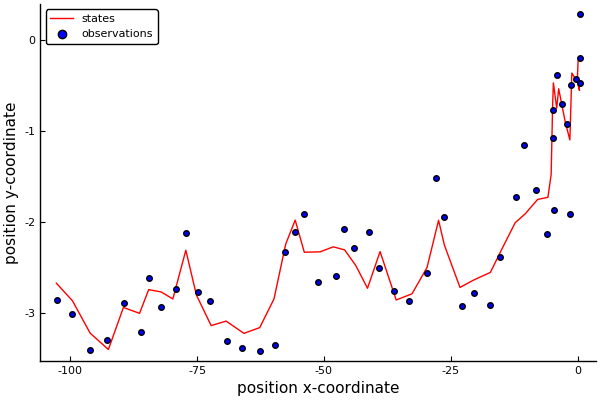

In [2]:
# Dimensionalities
N = 2
M = 2

# Length of time-series
T = 50

# Transition matrix of latent variables
transition = [1.0 1.0;0.0 1.0]

# Emission matrix for observed variables
emission = [1.0 0.;0. 1.0]

# Process noise (latent variables)
process_noise = [0.2 0.;0. 0.1]

# Measurement noise (observations)
measurement_noise = [0.1 0.;0. 0.1]

# Preallocate data arrays
states = zeros(N, T)
observations = zeros(M, T)

# Initial state
state_0 = [0., 0.]

# Keep previous state in memory
state_tmin = state_0

# Generate data for entire time-series
for t = 1:T
    
    # Transition from previous state
    states[:,t] = sample(ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=transition * state_tmin, v=process_noise))
    
    # Emission of current state
    observations[:,t] = sample(ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=emission * states[:,t], v=measurement_noise))
    
    # Update previous state
    state_tmin = states[:,t]
    
end

# Visualization of states
plot(states[1,:], states[2,:], color="red", label="states", grid=false, xlabel="position x-coordinate", ylabel="position y-coordinate")
scatter!(observations[1,:], observations[2,:], color="blue", label="observations")

Since we don't have a time-axis anymore, it is hard to see how the process evolves. Animating the path is helpful.

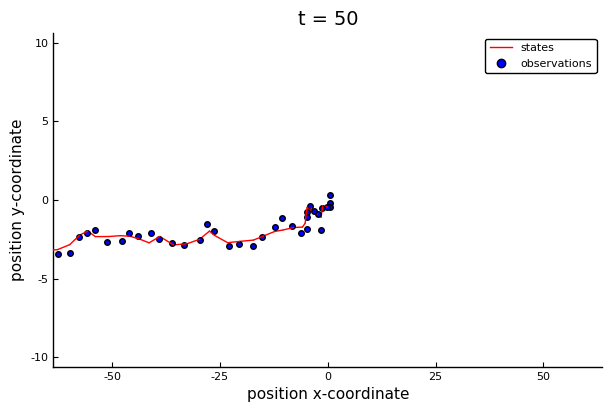

Plots.AnimatedGif("/home/wmkouw/Dropbox/Courses/tueindhoven/5SSD0 - Bayesian Machine Learning & Information Processing/tmp/BMLIP/lessons/exercises/probprog_solutions/example-GDS.gif")
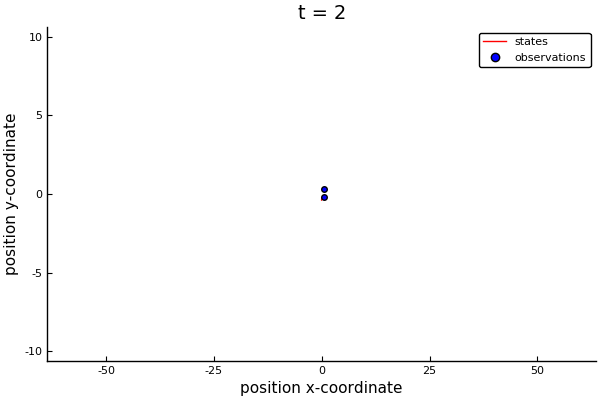

In [3]:
"Animation of cart's path"

# Plot initial state
plot([states[1,1]], [states[2,1]], 
           color="red", 
           label="states", 
           grid=false, 
           xlabel="position x-coordinate", 
           ylabel="position y-coordinate", 
           xlims=[-60,60], 
           ylims=[-10,10])

# Plot initial observation
scatter!([observations[1,1]], [observations[2,1]], color="blue", label="observations")

anim = @animate for t = 2:T
    
    title!("t = "*string(t))
    
    # Plot new state
    plot!([states[1,t-1:t]], [states[2,t-1:t]], color="red", label="")
    
    # Plot new observation
    scatter!([observations[1,t]], [observations[2,t]], color="blue", label="")
    
end

gif(anim, "example-GDS.gif", fps = 3)

## Model specification

The Bayesian formulation of the LGDS state-space model takes the following form:

$$\begin{align}
p(x_k \mid x_{k-1}) =&\ \mathcal{N}(x_k \mid A x_{k-1}, Q)\\
p(y_k \mid x_k) =&\ \mathcal{N}(y_k \mid B x_k, R) \, .
\end{align}$$

We can easily specify the states and observations as multivariate Gaussian distributions. If we do not know the process and measurement noise matrices, we can add Wishart priors to them. Similarly, if we don't know the transition and emission matrices, we can priors for them as well. Since these can take on negative values, we would specify them as multivariate Gaussians;

$$\begin{align}
p(Q) \sim&\ \mathcal{W}(V_Q, n_Q) \\
p(R) \sim&\ \mathcal{W}(V_R, n_R) \\
p(A) \sim&\ \mathcal{N}(m_A, S_A) \\
p(B) \sim&\ \mathcal{N}(m_B, S_B) \, .
\end{align}$$

ForneyLab is designed for dynamical systems and excels when using Gaussians. It can do inference in a recursive, time-slice-based manner. That is, it performs a series of variational message passing iterations in each time-slice, moving forward through time.

### Model 1: state estimation

We will stick to state estimation for now. We will dynamically "fix" the previous states and observations, allowing us to focus the variational message passing procedure to the "current" state and observation in the time-slice.

In [4]:
# Initialize a graph
graph1 = FactorGraph()

# Preallocate variable arrays
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

# Prior for initial state
@RV x_0 ~ GaussianMeanPrecision([0., 0.], [1. 0.;0. 1.])

# Keep previous state in memory
x_tmin = x_0

# Iterate over time
for t = 1:T
    
    # State transition
    @RV ϵ_t ~ GaussianMeanVariance([0., 0.], process_noise)
    @RV x[t] = transition * x_tmin + ϵ_t
    
    # State transition
    @RV η_t ~ GaussianMeanVariance([0., 0.], measurement_noise)
    @RV y[t] = emission * x[t] + η_t
    
    # Tell FL that y is observed
    placeholder(y[t], :y, index=t, dims=(2,))
    
    # Update previous state
    x_tmin = x[t]
end

We'll now construct the algorithm and infer results. 

In [5]:
# Number of optimization iterations
num_iterations = 10

# Define recognition distribution
q = RecognitionFactorization(x, ids=[:X])

# Generate variational algorithm
algo = variationalAlgorithm(q)

# Load algorithm
eval(Meta.parse(algo))

# Initialize recognition distribution marginals
marginals = Dict{Symbol, ProbabilityDistribution}()
for t = 1:T
    marginals[:x_*t] = vague(ForneyLab.GaussianMeanVariance, 2)
end

# Initialize data
data = Dict(:y => [observations[:,t] for t = 1:T])

# Run algorithm
for i = 1:num_iterations
    
    # Update states
    stepX!(data, marginals)
    
end;

Let's check whether everything went ok. We'll visualize the state estimations.

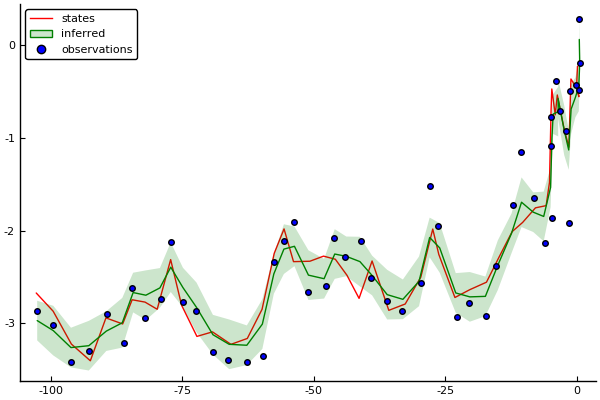

In [6]:
# Preallocation
states_estimated = zeros(2,T)
states_sem = zeros(2,T)

for t = 1:T
    
    # State estimates
    states_estimated[:,t] = mean(marginals[:x_*t])
    
    # Variance of the state estimates
    states_sem[:,t] = sqrt.(var(marginals[:x_*t]))
end

# Visualization
plot(states[1,:], states[2,:], color="red", label="states", grid=false)
plot!(states_estimated[1,:], states_estimated[2,:], ribbon=[states_sem, states_sem], fillalpha=0.2, color="green", label="inferred")
scatter!(observations[1,:], observations[2,:], color="blue", label="observations")

We're going to inspect some messages. Let's open up the algorithm. Let's look up the marginal for $x_1$. It will be the multiplication of two messages, one consisting of the state transition prediction and the other consisting of the measurement likelihood. 

In [7]:
# Find index of marginal computation in algorithm string
ix = findfirst("marginals[:x_1]", algo)

# Print line at index
println(algo[ix[1]:ix[end]+42])

marginals[:x_1] = messages[351].dist * messages[347].dist


We can re-run the inference algorithm such that we get an array of all messages in the graph.

In [8]:
# Re-initialize recognition distribution marginals
marginals = Dict{Symbol, ProbabilityDistribution}()
for t = 1:T
    marginals[:x_*t] = vague(ForneyLab.GaussianMeanVariance, 2)
end

# Initialize messages
messages = Vector{Message}(undef, 698)

# Re-run inference algorithm now including the message array
for i = 1:num_iterations
    
    # Update states
    stepX!(data, marginals, messages)
    
end;

Let's visualize the two messages and the resulting state marginal.

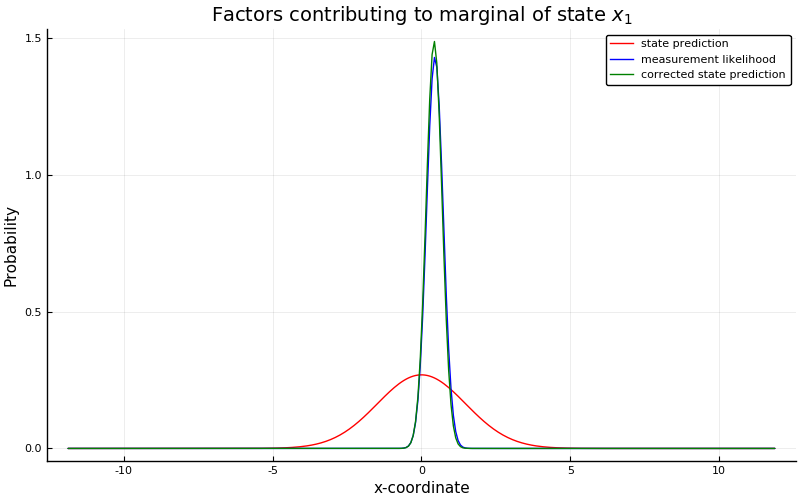

In [9]:
# Collect state transition prediction
m_statepred = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, messages[351].dist)

# Collect measurement likelihood
m_likelihood = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, messages[347].dist)

# Collect corrected prediction
state_marginal = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, marginals[:x_1])

# # Extract x-coordinates
m_statepred_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_statepred.params[:m][1], v=m_statepred.params[:v][1,1])
m_likelihood_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_likelihood.params[:m][1], v=m_likelihood.params[:v][1,1])
state_marginal_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=state_marginal.params[:m][1], v=state_marginal.params[:v][1,1])

# Plot of the prediction, noisy measurement, and corrected prediction for x-coordinate
plot_messages(m_statepred_x, m_likelihood_x, state_marginal_x)
title!(L"Factors contributing to marginal of state $x_1$")

The state marginal is dominated by the observation, because the state prediction is based purely on a prior distribution. If we now look at the situation for $x_2$, things should be different.

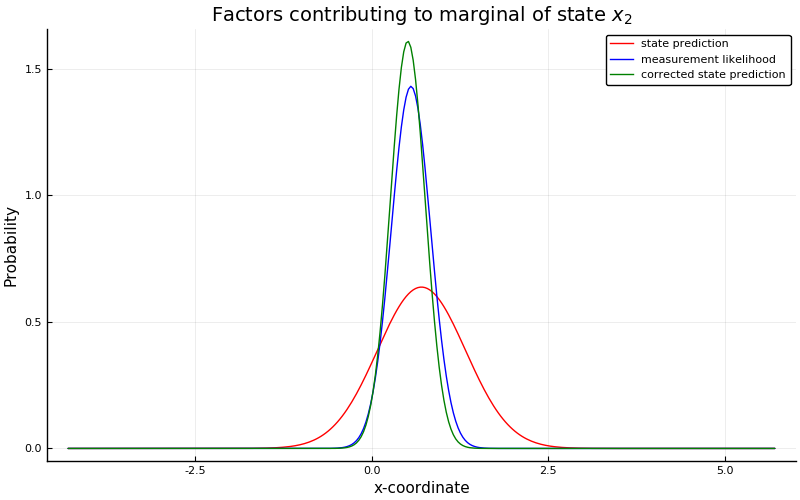

In [10]:
# Collect state transition prediction
m_statepred = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, messages[357].dist)

# Collect measurement likelihood
m_likelihood = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, messages[343].dist)

# Collect corrected prediction
state_marginal = convert(ProbabilityDistribution{Multivariate, GaussianMeanVariance}, marginals[:x_2])

# # Extract x-coordinates
m_statepred_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_statepred.params[:m][1], v=m_statepred.params[:v][1,1])
m_likelihood_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_likelihood.params[:m][1], v=m_likelihood.params[:v][1,1])
state_marginal_x = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=state_marginal.params[:m][1], v=state_marginal.params[:v][1,1])

# Plot of the prediction, noisy measurement, and corrected prediction for x-coordinate
plot_messages(m_statepred_x, m_likelihood_x, state_marginal_x)
title!(L"Factors contributing to marginal of state $x_2$")

Now, the state prediction has more influence on the actual state marginal.

### Model 2: estimate states and process noise

Weĺl now expand on the model. What if we don't know process noise? Can we estimate it simultaneously?

In [11]:
# Initialize a graph
graph2 = FactorGraph()

# Preallocate variable arrays
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

# Prior for process noise
@RV Q ~ Wishart([1. 0.;0. 1.], 2)

# Prior for initial state
@RV x_0 ~ GaussianMeanPrecision([0., 0.], [1. 0.;0. 1.])

# Keep previous state in memory
x_tmin = x_0

# Iterate over time
for t = 1:T
    
    # State transition
    @RV ϵ_t ~ GaussianMeanPrecision([0., 0.], Q)
    @RV x[t] = transition * x_tmin + ϵ_t 
    
    # State transition
    @RV η_t ~ GaussianMeanVariance([0., 0.], measurement_noise)
    @RV y[t] = emission * x[t] + η_t
    
    # Tell FL that y is observed
    placeholder(y[t], :y, index=t, dims=(2,))
    
    # Update previous state
    x_tmin = x[t]
end

We'll need to add a recognition factor for the process noise covariance matrix $Q$.

In [12]:
# Define recognition distribution
q = RecognitionFactorization(x, Q, ids=[:X, :Q])

# Generate variational algorithm
algo = variationalAlgorithm(q)

# Load algorithm
eval(Meta.parse(algo))

# Initialize recognition distribution marginals
marginals = Dict{Symbol, ProbabilityDistribution}()
marginals[:Q] = vague(ForneyLab.Wishart, 2)
for t = 1:T
    marginals[:x_*t] = vague(ForneyLab.GaussianMeanVariance, 2)
end

# Initialize data
data = Dict(:y => [observations[:,t] for t = 1:T])

# Run algorithm
for i = 1:num_iterations
    
    # Update states
    stepX!(data, marginals)
    
    # Update process noise estimate
    stepQ!(data, marginals)
    
end;

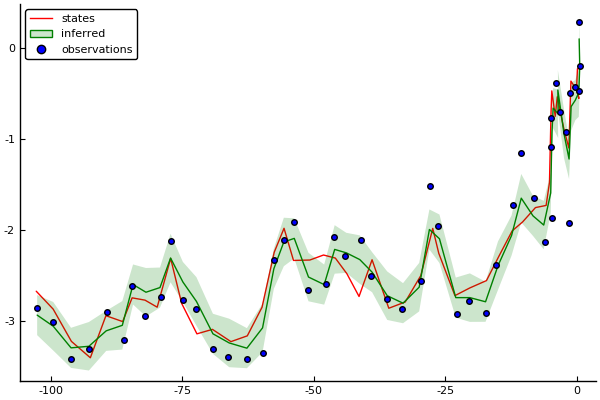

In [13]:
# Preallocation
states_estimated = zeros(2,T)
states_sem = zeros(2,T)

for t = 1:T
    
    # State estimates
    states_estimated[:,t] = mean(marginals[:x_*t])
    
    # Variance of the state estimates
    states_sem[:,t] = sqrt.(var(marginals[:x_*t]))
end

# Visualization
plot(states[1,:], states[2,:], color="red", label="states", grid=false)
plot!(states_estimated[1,:], states_estimated[2,:], ribbon=[states_sem, states_sem], fillalpha=0.2, color="green", label="inferred")
scatter!(observations[1,:], observations[2,:], color="blue", label="observations")

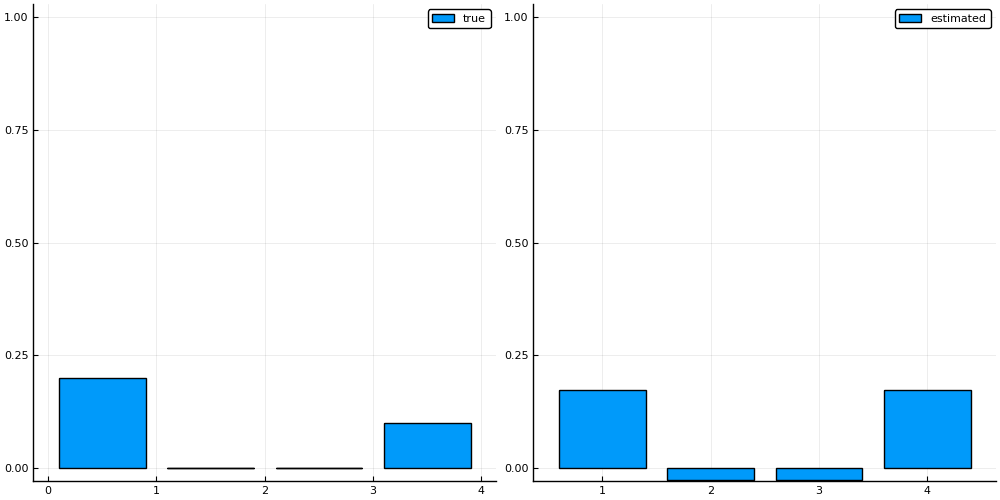

In [14]:
# Estimated process noise
pnoise_estimate = inv(mean(marginals[:Q]))

# Visualization
l = @layout [a b]
h1 = Plots.bar(0:4, reshape(process_noise, (4,)), label="true", ylims=[0., 1.])
h2 = Plots.bar(reshape(pnoise_estimate, (4,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))

### Model 3: estimate states, transition and process noise

We won't be estimating the transition matrix simultaneously. Multiplications of variables require the construction of a "composite node", which is a larger factor with internal variables integrated out and custom messages to external variables. It relates to the concept of 'drawing a box' around variables, as Bert discussed in his lecture on Factor Graphs. We won't be constructing composite nodes in this mini-course, but if you're interested you can ask us about it.

One of the PhD students in the lab has built an \emph{AutoRegressive} node, which is a composite node that buffers previous states and multiplies with a variable transition matrix. This node allows ForneyLab to run adaptive Kalman filters and adaptive auto-regressive models. We're using it for audio processing applications. This is the kind of research we do in BIASlab. If you're excited and curious, ask us about possible master research projects.

### Assignment: simultaneous process and measurement noise estimation

For theoretical reasons, it is difficult to estimate process and measurement noise simultaneously. To see this, in this assignment you're going to extend Model 2 to include measurement noise. What happens to the estimates when you change priors?

In [ ]:
### Your code here